In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#### Import into four different Data Frames: 
(1) sameAs links with their error degrees; <br />
(2) the manually annotated terms; <br />
(3) the non-singleton identity sets after discarding links with error degree > 0.4; <br />
(4) the non-singleton identity sets after discarding links with error degree > 0.99 

In [163]:
df_links = pd.read_csv("data/sameas-error-degree.csv", sep=";", low_memory=False)
df_terms = pd.read_csv("data/annotated-terms.csv", sep=";", low_memory=False)
df_closure_04 = pd.read_csv("data/non-singleton-sets-04.csv", sep=";", low_memory=False)
df_closure_09 = pd.read_csv("data/non-singleton-sets-099.csv", sep=";", low_memory=False)

In [162]:
df_links.sample(5)

,term1,term2,error_degree,weight,eq_id,eq_size,community
116668596,http://no.dbpedia.org/resource/Barack_Obama,http://pms.dbpedia.org/resource/Barack_Obama,0.24,2,5723,14916,0
116669406,http://tl.dbpedia.org/resource/Barack_Obama,http://war.dbpedia.org/resource/Barack_Obama,0.24,2,5723,14916,0
116669350,http://tg.dbpedia.org/resource/Барак_Обама,http://yo.dbpedia.org/resource/Barack_Obama,0.24,2,5723,14916,0
116665371,http://es.dbpedia.org/resource/Barack_Obama,http://my.dbpedia.org/resource/ဘာရတ်အိုဘားမား,0.24,2,5723,14916,0
116668816,http://pt.dbpedia.org/resource/Barack_Obama,http://sco.dbpedia.org/resource/Barack_Obama,0.24,2,5723,14916,0


In [7]:
df_terms.sample(5)

,term,entity,class
273,http://dbpedia.org/resource/Borack_Obama,Barack Obama,1
65,http://ja.dbpedia.org/resource/%E3%83%90%E3%83...,Can't tell,0
287,http://dbpedia.org/resource/OBAMA%21,Barack Obama,1
218,http://dbpedia.org/resource/Barack_II,Barack Obama,1
101,http://ne.dbpedia.org/resource/%E0%A4%AC%E0%A4...,Can't tell,0


In [9]:
df_closure_04.sample(5)

,new_eq_id,term
88,5698081,http://sh.dbpedia.org/resource/Barack_Obama
113,5698081,http://war.dbpedia.org/resource/Barack_Obama
32,5698081,http://fa.dbpedia.org/resource/باراک_اوباما
38,5698081,http://gl.dbpedia.org/resource/Barack_Obama
82,5698081,http://pt.dbpedia.org/resource/Barack_Obama


In [10]:
df_closure_09.sample(5)

,new_eq_id,term
106,18209200,http://dbpedia.org/resource/Barack_Obama_Biogr...
127,18209200,http://dbpedia.org/resource/Barak_hussein_obama
117,18209200,http://dbpedia.org/resource/Barack_obabma
160,18209200,http://dbpedia.org/resource/O'Bama
268,18209200,http://my.dbpedia.org/resource/ဘာရတ်အိုဘားမား


The 440 terms in the Barack Obama Identity Set in the LOD Cloud. <br/> 
All these terms should refer to the same real world entity, but after manual evaluation, they seem to refer to 8 different real world entities.
We couldn't tell what 102 terms refer to.

In [20]:
df_terms.groupby(['entity']).count().sort_values(by='term', ascending=False) 

,term,class
entity,,
Barack Obama,260,260
Can't tell,102,102
Barack Obama's Presidency,47,47
Barack Obama's Presidential transition,22,22
Barack Obama's Senate Career,5,5
Barack Obama's Biography,1,1
Barack Obama's Photos,1,1
Barack Obama's Presidential Center,1,1
Black President,1,1


In [35]:
canttell_links = 0
wrong_links = 0
correct_links = 0
canttell_pairs = 0
wrong_pairs = 0
correct_pairs = 0

for index, row in df_links.iterrows():
    df1 = df_terms[df_terms['term']==row["term1"]]
    df2 = df_terms[df_terms['term']==row["term2"]]
    c1 = df1.iloc[0]['class']
    c2 = df2.iloc[0]['class']
    if c1==0 or c2==0:
        canttell_pairs += 1
        canttell_links += row["weight"]
    elif c1==c2:
        correct_pairs +=1
        correct_links += row["weight"]
    elif c1!=c2:
        wrong_pairs +=1
        wrong_links += row["weight"]

total_links = correct_links+wrong_links+canttell_links
total_pairs = correct_pairs+wrong_pairs+canttell_pairs
print("Total links in Obama Identity Set:", total_links)
print("Correct links in Obama Identity Set:", correct_links)
print("Wrong links in Obama Identity Set:", wrong_links)
print("Can't tell links in Obama Identity Set:", canttell_links)
print("----------------")
print("Total pairs in Obama Identity Set:", total_pairs)
print("Correct pairs in Obama Identity Set:", correct_pairs)
print("Wrong pairs in Obama Identity Set:", wrong_pairs)
print("Can't tell pairs in Obama Identity Set:", canttell_pairs)

Total links in Obama Identity Set: 14916
Correct links in Obama Identity Set: 14587
Wrong links in Obama Identity Set: 26
Can't tell links in Obama Identity Set: 303
----------------
Total pairs in Obama Identity Set: 7615
Correct pairs in Obama Identity Set: 7366
Wrong pairs in Obama Identity Set: 17
Can't tell pairs in Obama Identity Set: 232


In [99]:
def evaluatethreshold(threshold, output):
    canttell = 0
    TP=0
    TN=0
    FP=0
    FN=0
    for index, row in df_links.iterrows():
        df1 = df_terms[df_terms['term']==row["term1"]]
        df2 = df_terms[df_terms['term']==row["term2"]]
        c1 = df1.iloc[0]['class']
        c2 = df2.iloc[0]['class']
        if c1==0 or c2==0:
            canttell += row["weight"]
        elif c1==c2:
            if row["error_degree"] > threshold:
                FP += row["weight"]
            else:
                TN += row["weight"]
        elif c1!=c2:
            if row["error_degree"] > threshold:
                TP += row["weight"]
            else:
                FN += row["weight"]
            
    precision = round((TP/(TP+FP))*100, 2)
    recall =  round((TP/(TP+FN))*100, 2)
    accuracy = round(((TP+TN)/(TP+TN+FP+FN))*100,2)
    f_measure = round(((2*recall*precision)/(recall+precision)),2)
    result = [precision, recall, accuracy, f_measure, threshold]
    if output == True:
        print("When threshold is set at", threshold)
        print("-----------------")
        print("TP:", TP)
        print("TN:", TN)
        print("FP:", FP)
        print("FN:", FN)
        print("Can't tell:", canttell)
        print("-- Precision =", precision, "%")
        print("-- Recall =", recall, "%")
        print("-- Accuracy =", accuracy, "%")
        print("-- F1-score =", f_measure, "%")
    return result

In [100]:
result_099 = evaluatethreshold(0.99, True)

When threshold is set at 0.99
-----------------
TP: 2
TN: 14587
FP: 0
FN: 24
Can't tell: 303
-- Precision = 100.0 %
-- Recall = 7.69 %
-- Accuracy = 99.84 %
-- F1-score = 14.28 %


In [101]:
result_04 = evaluatethreshold(0.4, True)

When threshold is set at 0.4
-----------------
TP: 26
TN: 13792
FP: 795
FN: 0
Can't tell: 303
-- Precision = 3.17 %
-- Recall = 100.0 %
-- Accuracy = 94.56 %
-- F1-score = 6.15 %


In [102]:
print(result_099)
print(result_04)

[100.0, 7.69, 99.84, 14.28, 0.99]
[3.17, 100.0, 94.56, 6.15, 0.4]


In [109]:
precision_list = []
recall_list = []
accuracy_list = []
f_measure_list = []
threshold_list = []
threshold = 0
while threshold < 1: 
    result = []
    result = evaluatethreshold(threshold, False)
    print(result)
    precision_list.append(result[0])
    recall_list.append(result[1])
    accuracy_list.append(result[2])
    f_measure_list.append(result[3])
    threshold_list.append(result[4])
    threshold = round((threshold+0.01),2)
    

[0.18, 100.0, 0.18, 0.36, 0]
[0.18, 100.0, 0.18, 0.36, 0.01]
[0.18, 100.0, 0.18, 0.36, 0.02]
[0.18, 100.0, 0.18, 0.36, 0.03]
[0.18, 100.0, 0.18, 0.36, 0.04]
[0.18, 100.0, 0.18, 0.36, 0.05]
[0.18, 100.0, 0.18, 0.36, 0.06]
[0.18, 100.0, 0.18, 0.36, 0.07]
[0.18, 100.0, 0.18, 0.36, 0.08]
[0.18, 100.0, 0.18, 0.36, 0.09]
[0.18, 100.0, 0.18, 0.36, 0.1]
[0.18, 100.0, 0.18, 0.36, 0.11]
[0.18, 100.0, 0.18, 0.36, 0.12]
[0.18, 100.0, 0.18, 0.36, 0.13]
[0.18, 100.0, 0.18, 0.36, 0.14]
[0.18, 100.0, 0.18, 0.36, 0.15]
[0.18, 100.0, 0.18, 0.36, 0.16]
[0.18, 100.0, 0.18, 0.36, 0.17]
[0.18, 100.0, 0.18, 0.36, 0.18]
[0.18, 100.0, 0.18, 0.36, 0.19]
[0.18, 100.0, 0.18, 0.36, 0.2]
[0.18, 100.0, 0.18, 0.36, 0.21]
[0.18, 100.0, 0.18, 0.36, 0.22]
[0.18, 100.0, 0.18, 0.36, 0.23]
[3.17, 100.0, 94.56, 6.15, 0.24]
[3.17, 100.0, 94.56, 6.15, 0.25]
[3.17, 100.0, 94.56, 6.15, 0.26]
[3.17, 100.0, 94.56, 6.15, 0.27]
[3.17, 100.0, 94.56, 6.15, 0.28]
[3.17, 100.0, 94.56, 6.15, 0.29]
[3.17, 100.0, 94.56, 6.15, 0.3]
[3.17, 

In [110]:
print(threshold_list)
print(precision_list)
print(recall_list)
print(accuracy_list)
print(f_measure_list)

[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
[0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 3.17, 1.87, 1.9, 3.91, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.56, 6.5

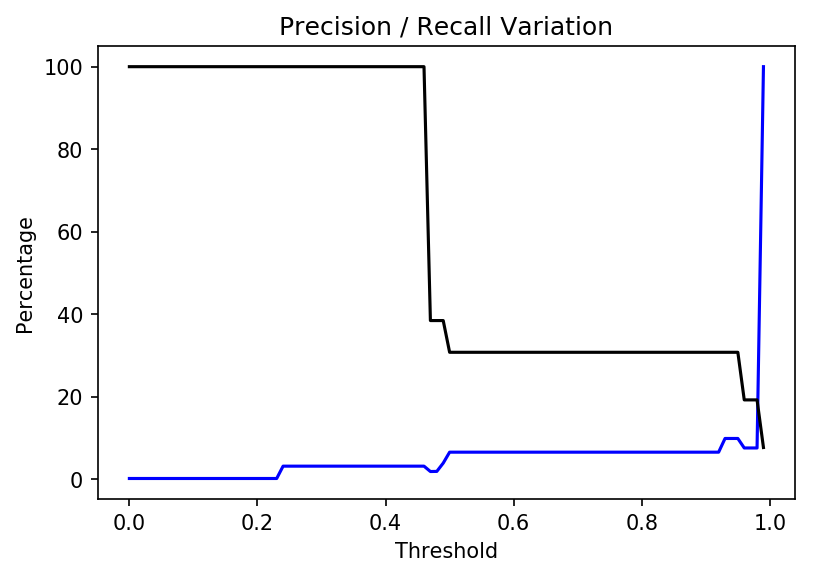

In [177]:
plt.plot(threshold_list, precision_list, color='blue')
plt.plot(threshold_list, recall_list,  color='black')
#plt.plot(threshold_list, accuracy_list, #ls='dashed', color='b')
#plt.plot(threshold_list, f_measure_list, color='black')
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Precision / Recall Variation')
plt.show()


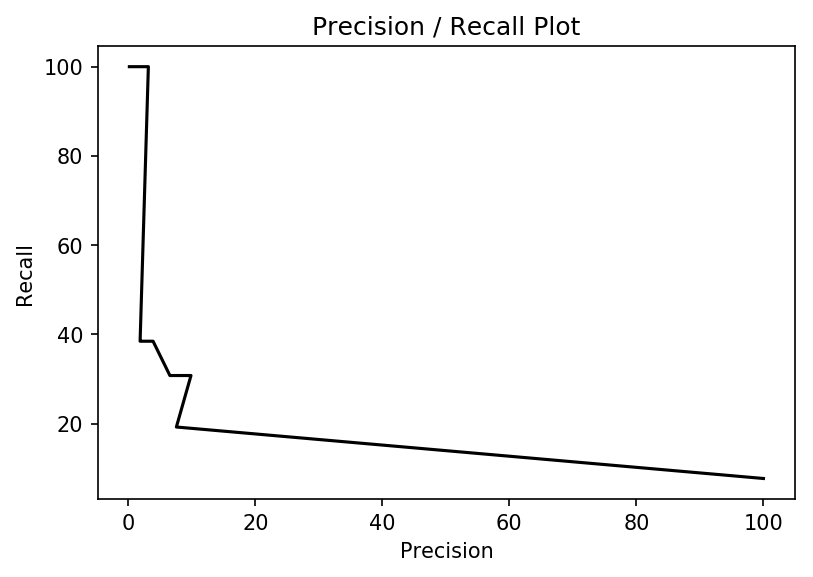

In [178]:
plt.plot(precision_list, recall_list,  color='black')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision / Recall Plot')
plt.show()

In [176]:
df_closure_09.groupby('new_eq_id').count()

,term
new_eq_id,
18209200,362
18209201,78


In [171]:
df_B1 = df_closure_09[df_closure_09['new_eq_id']==18209200]
df_B2 = df_closure_09[df_closure_09['new_eq_id']==18209201]
df_C1 = df_closure_04[df_closure_04['new_eq_id']==5698081]

result_B1 = [0,0,0,0,0,0,0,0,0]
result_B2 = [0,0,0,0,0,0,0,0,0]
result_C1 = [0,0,0,0,0,0,0,0,0]
for index, row in df_B1.iterrows(): 
    df1 = df_terms[df_terms['term']==row["term"]]
    c1 = df1.iloc[0]['class']
    result_B1[c1]+=1
for index, row in df_B2.iterrows(): 
    df2 = df_terms[df_terms['term']==row["term"]]
    c2 = df2.iloc[0]['class']
    result_B2[c2]+=1
for index, row in df_C1.iterrows(): 
    df3 = df_terms[df_terms['term']==row["term"]]
    c3 = df3.iloc[0]['class']
    result_C1[c3]+=1

In [172]:
result_B1

[92, 260, 0, 1, 5, 1, 1, 1, 1]

In [173]:
result_B2

[10, 0, 47, 21, 0, 0, 0, 0, 0]

In [174]:
result_C1

[1, 120, 0, 0, 0, 0, 0, 0, 0]

In [184]:
canttell_links = 0
wrong_links = 0
correct_links = 0
canttell_pairs = 0
wrong_pairs = 0
correct_pairs = 0
correct_sym_pairs = 0
wrong_sym_pairs = 0

for index, row in df_links.iterrows():
    df1 = df_terms[df_terms['term']==row["term1"]]
    df2 = df_terms[df_terms['term']==row["term2"]]
    c1 = df1.iloc[0]['class']
    c2 = df2.iloc[0]['class']
    if c1==0 or c2==0:
        canttell_pairs += 1
        canttell_links += row["weight"]
    elif c1==c2:
        error_degree = row["error_degree"]
        if row["weight"] == 2:
            error_degree = error_degree *2
            correct_sym_pairs += 1
            #print("Correct", c1, "<->", c2, ":", error_degree)
    elif c1!=c2:
        error_degree = row["error_degree"]
        if row["weight"] == 2:
            error_degree = error_degree *2
            wrong_sym_pairs += 1
            print("Wrong", c1, "<->", c2, ":", error_degree)
print("Number of correct symmetrical pairs:", correct_sym_pairs)
print("Number of wrong symmetrical pairs:", wrong_sym_pairs)

Wrong 2 <-> 3 : 0.94
Wrong 2 <-> 3 : 0.94
Wrong 3 <-> 1 : 1.0
Wrong 3 <-> 2 : 0.94
Wrong 3 <-> 2 : 0.94
Wrong 3 <-> 2 : 0.94
Wrong 3 <-> 2 : 0.94
Wrong 3 <-> 2 : 0.94
Wrong 3 <-> 2 : 0.94
Number of correct symmetrical pairs: 7221
Number of wrong symmetrical pairs: 9
